# FINAL

## Importing dependencies

In [112]:
import pandas as pd
import numpy as np

import tensorflow as tf
import logging
import sys
import contextlib

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

from matplotlib import pyplot as plt
# for custom CNN
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Loading dataset

In [113]:
data = pd.read_csv("final_df_combined.csv")

In [114]:
print(data.value_counts().sum())

44262


In [115]:
data

,image_path,label,source
0,classifier_one_data/../input/ocular-disease-re...,Normal,classifier_one
1,classifier_one_data/../input/ocular-disease-re...,Normal,classifier_one
2,classifier_one_data/../input/ocular-disease-re...,Diabetic Retinopathy,classifier_one
3,classifier_one_data/../input/ocular-disease-re...,Diabetic Retinopathy,classifier_one
4,classifier_one_data/../input/ocular-disease-re...,Diabetic Retinopathy,classifier_one
...,...,...,...
44257,glaucoma_data/archive/ORIGA/ORIGA/Images/646.jpg,Glaucoma,glaucoma
44258,glaucoma_data/archive/ORIGA/ORIGA/Images/647.jpg,Glaucoma,glaucoma
44259,glaucoma_data/archive/ORIGA/ORIGA/Images/648.jpg,Glaucoma,glaucoma
44260,glaucoma_data/archive/ORIGA/ORIGA/Images/649.jpg,Normal,glaucoma


In [116]:
print(data['label'].unique())
print(data['label'].value_counts().unique())

['Normal' 'Diabetic Retinopathy' 'Other' 'Pathological Myopia'
 'Hypertension' 'Cataract' 'Age related Macular Degeneration' 'Glaucoma'
 'Mild DR' 'Moderate DR' 'Proliferative DR' 'Severe DR']
[30231  5288  2438  1608  1331   872   708   452   266   232   128]


In [117]:
data['label'].value_counts()

label
Normal                              30231
Moderate DR                          5288
Mild DR                              2438
Diabetic Retinopathy                 1608
Cataract                             1331
Severe DR                             872
Other                                 708
Proliferative DR                      708
Glaucoma                              452
Age related Macular Degeneration      266
Pathological Myopia                   232
Hypertension                          128
Name: count, dtype: int64

In [118]:
# data.drop(columns=['Unnamed: 0.1','Unnamed: 0'], inplace=True)
data.head()

,image_path,label,source
0,classifier_one_data/../input/ocular-disease-re...,Normal,classifier_one
1,classifier_one_data/../input/ocular-disease-re...,Normal,classifier_one
2,classifier_one_data/../input/ocular-disease-re...,Diabetic Retinopathy,classifier_one
3,classifier_one_data/../input/ocular-disease-re...,Diabetic Retinopathy,classifier_one
4,classifier_one_data/../input/ocular-disease-re...,Diabetic Retinopathy,classifier_one


## Data preprocessing

In [119]:
data.head()

,image_path,label,source
0,classifier_one_data/../input/ocular-disease-re...,Normal,classifier_one
1,classifier_one_data/../input/ocular-disease-re...,Normal,classifier_one
2,classifier_one_data/../input/ocular-disease-re...,Diabetic Retinopathy,classifier_one
3,classifier_one_data/../input/ocular-disease-re...,Diabetic Retinopathy,classifier_one
4,classifier_one_data/../input/ocular-disease-re...,Diabetic Retinopathy,classifier_one


In [120]:
# Create a dictionary to map each unique label to an integer
label_mapping = {label: idx for idx, label in enumerate(data['label'].unique())}


In [121]:
# Apply the mapping to the label column
data['num_label'] = data['label'].map(label_mapping)
data

,image_path,label,source,num_label
0,classifier_one_data/../input/ocular-disease-re...,Normal,classifier_one,0
1,classifier_one_data/../input/ocular-disease-re...,Normal,classifier_one,0
2,classifier_one_data/../input/ocular-disease-re...,Diabetic Retinopathy,classifier_one,1
3,classifier_one_data/../input/ocular-disease-re...,Diabetic Retinopathy,classifier_one,1
4,classifier_one_data/../input/ocular-disease-re...,Diabetic Retinopathy,classifier_one,1
...,...,...,...,...
44257,glaucoma_data/archive/ORIGA/ORIGA/Images/646.jpg,Glaucoma,glaucoma,7
44258,glaucoma_data/archive/ORIGA/ORIGA/Images/647.jpg,Glaucoma,glaucoma,7
44259,glaucoma_data/archive/ORIGA/ORIGA/Images/648.jpg,Glaucoma,glaucoma,7
44260,glaucoma_data/archive/ORIGA/ORIGA/Images/649.jpg,Normal,glaucoma,0


In [122]:
data[['num_label', 'label']].value_counts()

num_label  label                           
0          Normal                              30231
9          Moderate DR                          5288
8          Mild DR                              2438
1          Diabetic Retinopathy                 1608
5          Cataract                             1331
11         Severe DR                             872
2          Other                                 708
10         Proliferative DR                      708
7          Glaucoma                              452
6          Age related Macular Degeneration      266
3          Pathological Myopia                   232
4          Hypertension                          128
Name: count, dtype: int64

In [123]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# Define your dataset
X = data['image_path']  # Your feature data
y = data['num_label']  # Your class labels

# Convert DataFrame or Series to a numpy array
X_array = X.values.reshape(-1,1)
y_array = y.values.reshape(-1,1)
source = data['source']

# Count the number of datapoints for each class
# class_counts = {0: 25802, 1: 5288, 2: 2438, 3: 872, 4: 708}

# Find the target number of datapoints
# target_count = class_counts[3]

# # Undersample the majority classes
# undersampler = RandomUnderSampler(sampling_strategy={label: target_count for label in class_counts.keys() if label != 4})
# X_resampled, y_resampled = undersampler.fit_resample(X_array, y_array)

# # Check the new class counts
# unique, counts = np.unique(y_resampled, return_counts=True)
# resampled_class_counts = dict(zip(unique, counts))
# print("Resampled class counts:", resampled_class_counts)

In [124]:
X

0        classifier_one_data/../input/ocular-disease-re...
1        classifier_one_data/../input/ocular-disease-re...
2        classifier_one_data/../input/ocular-disease-re...
3        classifier_one_data/../input/ocular-disease-re...
4        classifier_one_data/../input/ocular-disease-re...
                               ...                        
44257     glaucoma_data/archive/ORIGA/ORIGA/Images/646.jpg
44258     glaucoma_data/archive/ORIGA/ORIGA/Images/647.jpg
44259     glaucoma_data/archive/ORIGA/ORIGA/Images/648.jpg
44260     glaucoma_data/archive/ORIGA/ORIGA/Images/649.jpg
44261     glaucoma_data/archive/ORIGA/ORIGA/Images/650.jpg
Name: image_path, Length: 44262, dtype: object

In [125]:
new_X = []
# print(len(X))
for i in X:
  new_X.append(i)

In [126]:
new_X

['classifier_one_data/../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/0_right.jpg',
 'classifier_one_data/../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/1_right.jpg',
 'classifier_one_data/../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/2_right.jpg',
 'classifier_one_data/../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/4_right.jpg',
 'classifier_one_data/../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/5_right.jpg',
 'classifier_one_data/../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/6_right.jpg',
 'classifier_one_data/../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/7_right.jpg',
 'classifier_one_data/../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/8_right.jpg',
 'classifier_one_data/../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/9_right.jpg',
 'classifier_one_data/../input/ocular-disease-recognition-odir5k/ODIR-5K/

In [127]:
y

0        0
1        0
2        1
3        1
4        1
        ..
44257    7
44258    7
44259    7
44260    0
44261    7
Name: num_label, Length: 44262, dtype: int64

In [128]:
print(len(new_X), len(y))

44262 44262


In [129]:
# Create a new dataframe with resampled data
resampled_data = {'image_path': new_X,
        'num_label': y,
        'source': source}

balanced_data = pd.DataFrame(resampled_data)

# Display the first few rows of the new dataframe
balanced_data.sample(10)

,image_path,num_label,source
5526,classifier_one_data/../input/ocular-disease-re...,0,classifier_one
20519,DR_dataset_archive/resized_train_cropped/resiz...,9,dr
4834,classifier_one_data/../input/ocular-disease-re...,0,classifier_one
25275,DR_dataset_archive/resized_train_cropped/resiz...,0,dr
22355,DR_dataset_archive/resized_train_cropped/resiz...,9,dr
16126,DR_dataset_archive/resized_train_cropped/resiz...,0,dr
4734,classifier_one_data/../input/ocular-disease-re...,0,classifier_one
21046,DR_dataset_archive/resized_train_cropped/resiz...,0,dr
21840,DR_dataset_archive/resized_train_cropped/resiz...,0,dr
20320,DR_dataset_archive/resized_train_cropped/resiz...,0,dr


In [130]:
print(balanced_data.value_counts().sum())
print(balanced_data['num_label'].unique())
print(balanced_data['num_label'].value_counts().unique())

44262
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[30231  5288  2438  1608  1331   872   708   452   266   232   128]


In [131]:
print(balanced_data['image_path'][0])
print(balanced_data['image_path'][36000])
print(balanced_data['image_path'][44261])

classifier_one_data/../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/0_right.jpg
DR_dataset_archive/resized_train_cropped/resized_train_cropped/34830_left
glaucoma_data/archive/ORIGA/ORIGA/Images/650.jpg


In [132]:
# Add '.jpeg' to image_path where source is 'dr'
balanced_data.loc[balanced_data['source'] == 'dr', 'image_path'] += '.jpeg'
balanced_data

,image_path,num_label,source
0,classifier_one_data/../input/ocular-disease-re...,0,classifier_one
1,classifier_one_data/../input/ocular-disease-re...,0,classifier_one
2,classifier_one_data/../input/ocular-disease-re...,1,classifier_one
3,classifier_one_data/../input/ocular-disease-re...,1,classifier_one
4,classifier_one_data/../input/ocular-disease-re...,1,classifier_one
...,...,...,...
44257,glaucoma_data/archive/ORIGA/ORIGA/Images/646.jpg,7,glaucoma
44258,glaucoma_data/archive/ORIGA/ORIGA/Images/647.jpg,7,glaucoma
44259,glaucoma_data/archive/ORIGA/ORIGA/Images/648.jpg,7,glaucoma
44260,glaucoma_data/archive/ORIGA/ORIGA/Images/649.jpg,0,glaucoma


In [133]:
print(balanced_data['image_path'][0])
print(balanced_data['image_path'][36000])
print(balanced_data['image_path'][44261])

classifier_one_data/../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/0_right.jpg
DR_dataset_archive/resized_train_cropped/resized_train_cropped/34830_left.jpeg
glaucoma_data/archive/ORIGA/ORIGA/Images/650.jpg


### Splitting data

In [134]:
from sklearn.model_selection import train_test_split

# Step 1: Split balanced_data into 80% train and 20% temporary (for test + val)
train_data, temp_data = train_test_split(
    balanced_data, 
    test_size=0.2, 
    stratify=balanced_data['num_label'], 
    random_state=42
)

# Step 2: Split the temporary set into 50% test and 50% validation (10% of original data each)
test_data, val_data = train_test_split(
    temp_data, 
    test_size=0.5, 
    stratify=temp_data['num_label'], 
    random_state=42
)

# Now you have 80% train, 10% test, and 10% val sets
print(f"Train size: {len(train_data)}, Test size: {len(test_data)}, Validation size: {len(val_data)}")


Train size: 35409, Test size: 4426, Validation size: 4427


In [135]:
# train, val = train_test_split(balanced_data, test_size=0.2, random_state=42)

In [136]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5

### Rescaling image data

In [137]:
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Rescales pixel values from [0, 255] to [0, 1].
    rotation_range=30,              # Randomly rotates images by up to 30 degrees.
    width_shift_range=0.2,          # Randomly shifts images horizontally by 20% of the width.
    height_shift_range=0.2,         # Randomly shifts images vertically by 20% of the height.
    shear_range=0.2,                # Applies random shearing transformations by up to 20%.
    zoom_range=0.2,                 # Randomly zooms in or out by up to 20%.
    horizontal_flip=True,           # Randomly flips images horizontally (left to right).
    fill_mode='nearest'             # Fills in pixels that are lost after transformations using the nearest pixel values.
)
val_datagen = ImageDataGenerator(rescale=1./255)    # Rescales pixel values from [0, 255] to [0, 1].
test_datagen = ImageDataGenerator(rescale=1./255)    # Rescales pixel values from [0, 255] to [0, 1].val_datagen = ImageDataGenerator(rescale=1./255)    # Rescales pixel values from [0, 255] to [0, 1].


In [138]:
# create image data generators 

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,                                   # The dataframe containing image filenames and labels.
    # directory='DR_dataset_archive 3/resized_train_cropped/resized_train_cropped',  # The directory where the images are stored.
    x_col='image_path',                                     # The column in the dataframe that contains the image filenames.
    y_col='num_label',                                     # The column in the dataframe that contains the corresponding labels.
    target_size=IMAGE_SIZE,                            # Resizes all images to the specified target size (e.g., 224x224).
    batch_size=BATCH_SIZE,                             # Number of images to be returned in each batch during training.
    class_mode='raw'                                   # Specifies that labels should be returned as they are (numerical form).
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,                                     # The dataframe containing validation image filenames and labels.
    # directory='DR_dataset_archive 3/resized_train_cropped/resized_train_cropped/',  # Validation images directory.
    x_col='image_path',                                     # Column in the dataframe with image filenames.
    y_col='num_label',                                     # Column in the dataframe with the corresponding labels.
    target_size=IMAGE_SIZE,                            # Resizes validation images to the specified target size.
    batch_size=BATCH_SIZE,                             # Number of images in each batch during validation.
    class_mode='raw'                                   # Labels are returned in raw numerical form.
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,                                     # The dataframe containing validation image filenames and labels.
    # directory='DR_dataset_archive 3/resized_train_cropped/resized_train_cropped/',  # Validation images directory.
    x_col='image_path',                                     # Column in the dataframe with image filenames.
    y_col='num_label',                                     # Column in the dataframe with the corresponding labels.
    target_size=IMAGE_SIZE,                            # Resizes validation images to the specified target size.
    batch_size=BATCH_SIZE,                             # Number of images in each batch during validation.
    class_mode='raw'                                   # Labels are returned in raw numerical form.
)

Found 30276 validated image filenames.
Found 3788 validated image filenames.
Found 3806 validated image filenames.


/opt/anaconda3/envs/PRS1/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 5133 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/envs/PRS1/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 639 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/envs/PRS1/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 620 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


## Loading Xception

In [139]:
# loading a pre-trained MobileNetV2 model without the top layers (the classification head) 
# and preparing it to take input images of size 224x224x3 (height, width, and RGB channels)

base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

- weights='imagenet'
    - This specifies that the model should be loaded with weights pre-trained on the ImageNet dataset, which contains millions of labeled images across 1000 categories.
    - By using pre-trained weights, you can benefit from transfer learning, leveraging features the model learned during its training on the ImageNet dataset.

- 'include_top = False'
    - This means that the fully connected (dense) layers at the top of the model, which are specific to the ImageNet classification task, are excluded.
    - Instead, custom CNN layers are built on top of the MobileNetV2 model to adapt it for classifying retinal images for diabetic retinopathy.
    - MobileNetV2 without the top layers will output feature maps instead of final predictions, allowing to build a custom classifier on top of the base model.

In [140]:
# This gives you the feature maps extracted by the pre-trained MobileNetV2.
x = base_model.output   # x is the output of the MobileNetV2 base model

# Custom CNN layers 
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01), input_shape = (7,7))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Fully connected layers
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

/opt/anaconda3/envs/PRS1/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Building the model

In [141]:
# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Print the model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_3[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add_36[0][0]    

 Total params: 31,754,541 (121.13 MB)

 Trainable params: 31,696,429 (120.91 MB)

 Non-trainable params: 58,112 (227.00 KB)

In [142]:
# GlobalAveragePooling2D is used here instead of Flatten because it compresses the feature maps efficiently 
# while still retaining the most important information

In [143]:
# GlobalAveragePooling2D
    # This layer operates on the output of convolutional layers by calculating the average of each feature map. 
    # It reduces each feature map to a single number by taking the average across all spatial dimensions (height and width), resulting in a vector of averages.
    # It effectively reduces the spatial dimensions (height and width) of the feature maps to 1, 
        # leaving only the depth (number of filters). 
    # For example, if your convolutional output is of shape (7, 7, 512), after GlobalAveragePooling2D, 
        # it becomes a single vector of shape (512,) by averaging the values across the 7x7 grid for each of the 512 channels.

# Flatten
    # Flatten converts a multi-dimensional tensor into a one-dimensional vector. 
    # For example, if the input is of shape (7, 7, 512), Flatten will reshape it into a vector of shape (7 * 7 * 512) = (25088,).
    # This would retain more information than GlobalAveragePooling2D but also result in a much larger vector, 
    # potentially leading to overfitting and increased computational cost.

# Why only GlobalAveragePooling2D is used
    # GlobalAveragePooling2D is used to significantly reduce the number of parameters by summarizing each feature map into a single value, 
        # thus avoiding overfitting while still capturing essential information. 
        # This is especially useful in models like MobileNetV2, which are designed for efficiency and
            # often paired with pooling instead of flattening to maintain compactness.
    # If you were to Flatten first, you would drastically increase the size of the vector, 
        # leading to a much larger and potentially over-parameterized model, 
        # which could slow down training and increase the risk of overfitting.

### Freezing the model

In [144]:
# Freezing the model
for layer in base_model.layers:
    layer.trainable = False

### Model setup

In [145]:
initial_learning_rate = 0.001

In [146]:
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [147]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### learning rate scheduler

In [148]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [149]:
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)

In [150]:
# history = model.fit(train_generator, validation_data=val_generator, epochs=10)

### initiate the training process for the model 

In [152]:
history = model.fit(train_generator, validation_data=val_generator, epochs=15, callbacks=[early_stopping,lr_scheduler])

Epoch 1/15
947/947 ━━━━━━━━━━━━━━━━━━━━ 6382s 7s/step - accuracy: 0.7003 - loss: 8.6659 - val_accuracy: 0.7220 - val_loss: 26.4079 - learning_rate: 0.0010
Epoch 2/15
947/947 ━━━━━━━━━━━━━━━━━━━━ 2274s 2s/step - accuracy: 0.6782 - loss: 32.3573 - val_accuracy: 0.7220 - val_loss: 44.7437 - learning_rate: 0.0010
Epoch 3/15
947/947 ━━━━━━━━━━━━━━━━━━━━ 1570s 2s/step - accuracy: 0.6756 - loss: 50.6120 - val_accuracy: 0.7220 - val_loss: 58.4161 - learning_rate: 0.0010
Epoch 4/15
947/947 ━━━━━━━━━━━━━━━━━━━━ 1984s 2s/step - accuracy: 0.6709 - loss: 62.5475 - val_accuracy: 0.7220 - val_loss: 72.1243 - learning_rate: 0.0010
Epoch 5/15
947/947 ━━━━━━━━━━━━━━━━━━━━ 1781s 2s/step - accuracy: 0.6735 - loss: 76.3947 - val_accuracy: 0.7220 - val_loss: 84.0275 - learning_rate: 0.0010
Epoch 6/15
947/947 ━━━━━━━━━━━━━━━━━━━━ 1949s 2s/step - accuracy: 0.6652 - loss: 87.0447 - val_accuracy: 0.7220 - val_loss: 97.6449 - learning_rate: 0.0010
Epoch 7/15
947/947 ━━━━━━━━━━━━━━━━━━━━ 2222s 2s/step - accuracy:

In [153]:
model.save('version_1_xcep_15epochs.keras')
model.save('version_1_xcep_15epochs.weights.h5')
model.save('version_1_xcep_15epochs.h5')
# model.save('drdCustomCNN_MobileNetV2_50epochs.keras')

In [154]:
history.history

{'accuracy': [0.6942132115364075,
  0.6810675263404846,
  0.6776654720306396,
  0.6725789308547974,
  0.6714228987693787,
  0.671819269657135,
  0.6681529879570007,
  0.6648170351982117,
  0.6607874035835266,
  0.6586735248565674,
  0.6585744619369507],
 'loss': [13.948025703430176,
  36.23674774169922,
  53.89555358886719,
  65.43789672851562,
  79.5772933959961,
  90.2017822265625,
  102.19598388671875,
  110.97615051269531,
  119.73889923095703,
  129.65802001953125,
  141.5777130126953],
 'val_accuracy': [0.7220168709754944,
  0.7220168709754944,
  0.7220168709754944,
  0.7220168709754944,
  0.7220168709754944,
  0.7220168709754944,
  0.6642027497291565,
  0.7106652855873108,
  0.7220168709754944,
  0.7220168709754944,
  0.7111932635307312],
 'val_loss': [26.40790367126465,
  44.74372100830078,
  58.416141510009766,
  72.1242904663086,
  84.02750396728516,
  97.6449203491211,
  106.26805114746094,
  116.10706329345703,
  125.1575927734375,
  136.51341247558594,
  144.80503845214844

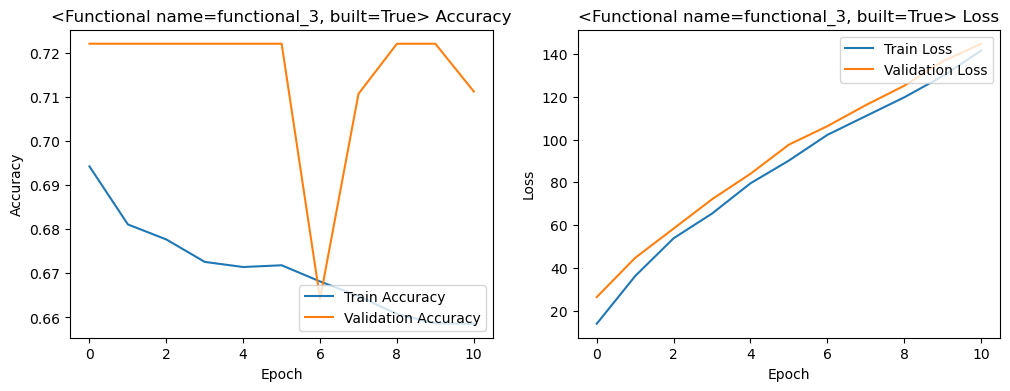

In [155]:
def plot_history(history, model_name):
    # Resumir la historia de la precisión
    plt.figure(figsize=(12, 4))

    # Gráfico de la precisión (accuracy)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Gráfico de la pérdida (loss)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.show()

# Iterar sobre el diccionario para generar los gráficos para cada modelo
plot_history(history, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


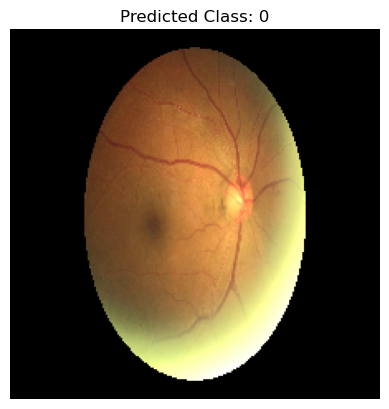

In [158]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = 'classifier_one_data/ODIR-5K/ODIR-5K/Training Images/11_right.jpg'  # Replace with your image path
# img_path = 'DR_dataset_archive 3/resized_train_cropped/resized_train_cropped_1024/16_right.jpeg'  # Replace with your image path
target_size = (224, 224)  # Model's expected input size
img = image.load_img(img_path, target_size=target_size)  # Resize image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize if needed

# Make predictions
prediction = model.predict(img_array)

# Interpret predictions
predicted_class = np.argmax(prediction)  # For multi-class
# For binary classification, use:
# predicted_class = (prediction > 0.5).astype(int)

# Display the result
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()


Inference

- wrongly predicted